# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from joblib import dump, load

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,f1_score
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Cleaning

#### In order to have a good understanding of the data, let us take time to clean and explore the data to determine the best procedure to clean up the data. This would enable us check for  missing value, visualizing the data distribution

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [6]:
from collections import Counter
def clean_portfolio(df):
    '''
    Description: 
        Deserialize the channels attribute to create column header for each of them along with the rest of the fields
        Merge the portfolio dataframe with the stacked data using the id field
        Drop the channels column from the dataset
        Rename the id field as offer_id
        Convert the duration data to hours instead of days
        drop any duplicates if any
    Input:
        - df: original portfolio dataframe
    Returns:
        - portfolio_df - the cleaned portfolio dataframe
    '''
    #deserialize the channels attribute to form each item to a column and their respective participations,
    #Convert categorical variable into dummy/indicator variables.
    #credit to https://stackoverflow.com/questions/70139966/how-to-transform-dataframe-column-containing-list-of-values-in-to-its-own-indivi
    portfolio_stacked = df.set_index('id')['channels'].map(Counter).apply(pd.Series).fillna(0, downcast='infer').reset_index()
    #merge the stacked df and the main df to form the collective data
    portfolio_df = df.merge(portfolio_stacked,how='left',on='id')
    #drop the original channels data
    portfolio_df.drop(columns='channels', inplace=True)
    
    #:portfolio represent Offers sent during 30-day test period (10 offers x 6 fields)
    #we can rename the portfolio id as the offer_id
    portfolio_df.rename(columns={'id':'offer_id'}, inplace=True)
    
    #convert the offertypes to columns
    offer_types = pd.get_dummies(portfolio_df['offer_type'].str.lower(), prefix="offer")
    portfolio_df = pd.concat([portfolio_df,offer_types],axis=1)
    portfolio_df.drop(columns='offer_type', inplace=True)
    
    #drop duplicated if any
    portfolio_df.drop_duplicates(inplace=True)
    
    return portfolio_df
    
portfolio_df = clean_portfolio(portfolio)

In [7]:
portfolio_df.head()

,difficulty,duration,offer_id,reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


In [8]:
import datetime
def clean_profile(df):
    '''
    Description: Clean the profile data frame.
        - Format the date field to a standard date format
        - Create a columns name for all confirmed users using afte inpecting the dataset
        - Extract dummy or indicator variable from the categorical attribute gender
        - Merge the dummy data with the main dataset
        - Drop any duplicates if need be
    Input:
        - df: original profile dataframe
    Returns:
        - profile_df - the cleaned profile dataframe
    '''
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    df['valid'] = (df.age != 118).astype(int)
    
    # Convert categorical variable line gender into dummy/indicator variables.
    #https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
    dummies = pd.get_dummies(df['gender'].str.lower(), prefix="gender").groupby(df['id']).max().reset_index()
    #dummies_years = pd.get_dummies(df['became_member_on'].apply(lambda x: x.year)).groupby(df['id']).max().reset_index()
    df['became_member_on']  = df['became_member_on'].apply(lambda x: int((pd.to_datetime(datetime.datetime.today())-pd.to_datetime(x)).days))

    #merge the stacked df and the main df to form the collective data
    profile_df = df.merge(dummies,how='left',on='id')
    #profile_df = df.merge(dummies_years,how='left',on='id')
    
    #we can rename the profile id as the user_id
    profile_df.rename(columns={'id':'customer_id'}, inplace=True)
    
    
    #drop duplicated if any
    profile_df.drop_duplicates(inplace=True)
    #profile_df.dropna(inplace=True)
    
    return profile_df

#Test the clean_profile function
profile_df = clean_profile(profile)
profile_df.head()

,age,became_member_on,gender,customer_id,income,valid,gender_f,gender_m,gender_o
0,118,1872,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0,0
1,55,1719,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,1,0,0
2,118,1357,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0,0
3,75,1786,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,1,0,0
4,118,1699,None,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0,0


In [9]:
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
def clean_transcript(df):
    '''
    Dataset contains the following attributes
    - person: (string/hash)
    - event: (string) offer received, offer viewed, transaction, offer completed
    - value: (dictionary) different values depending on event type (offers and transactions)
    offer id: (string/hash) not associated with any "transaction"
    amount: (numeric) money spent in "transaction
    reward: (numeric) money gained from "offer completed"
    (numeric) hours after start of test
    Description: Clean the profile data frame.
        - replace every space with underscore (_) to get a valid column name
        - Extract dummy or indicator variable from the categorical attribute event
        - Merge the dummy data with the main dataset
    
    Input:
        - df: original transcript dataframe
    Returns:
        - transcript_df - the cleaned transcript dataframe
    '''
    # Split event into several dummy columns
    #create expected fields
    transcript_df = df.copy()
    #introdue an underscore as a word separator for the events
    transcript_df.event = transcript_df.event.str.replace(' ', '_')
    
    #create offer_if, amount and reward fields from the value collections
    transcript_df['offer_id'] = df['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
    transcript_df['amount'] = df['value'].apply(lambda x: x['amount'] if 'amount' in x else None)
    transcript_df['reward'] = df['value'].apply(lambda x: x['reward'] if 'reward' in x else None)
    
    #Drop the value field
    transcript_df.drop('value',axis=1,inplace=True)
    transcript_df.rename(columns={'person':'customer_id'},inplace=True)
    
    #Convert transcript time from hours to days
    transcript_df['time'] = df['time'] / 24
    
    #transform the event attribute to create columns for each customer for the offers
    transcript_df = transcript_df.groupby(['customer_id','offer_id','event'])['time'].count().unstack()
    transcript_df.reset_index(level=[0,1],inplace = True)
    
    #Replace nan values with 0.0
    transcript_df.fillna(0.0, inplace = True)
    
    return transcript_df

transcript_df = clean_transcript(transcript)

In [15]:
transcript_df.head()

event,customer_id,offer_id,offer_completed,offer_received,offer_viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0


In [16]:
def combine_data(portfolio_df, profile_df, transcript_df):
    """ Combine transaction - transcript_df, demographic - profile_df and offer data - portfolio_df
    Input:
    - transcript_df
    - profile_df
    - portfolio_df
    Output:
    - merged_df: merged dataframe
    """
    #First merge the field that have a common join field (transcript_df and portfolio_df)
    member_transactions = pd.merge(transcript_df, portfolio_df, how='left', on='offer_id')
    
    #Merge the third dataframe with the common dataset
    merged_df = pd.merge(member_transactions, profile_df, how='left', on='customer_id')
    
    #Codify the offer_ids
    offer_idx = list(set(merged_df['offer_id']))
    
    for i in range(len(offer_idx)):
        merged_df['offer_id'] = merged_df['offer_id'].apply(lambda x: '{}'.format(i+1) if x == offer_idx[i] else x)
    
    #consider an offer to be successful if a viewed offer is completed
    merged_df.insert(loc=2, column='offer_successful', value=merged_df['offer_completed'] * merged_df['offer_viewed'])
    merged_df['offer_successful'] = merged_df['offer_successful'].apply(lambda x: 1.0 if x > 0 else 0.0)
    merged_df.drop(columns=['offer_completed', 'offer_received', 'offer_viewed'], inplace=True)
    
    return merged_df
    
merged_df = combine_data(portfolio_df, profile_df, transcript_df)

In [17]:
merged_df.shape

(63288, 21)

# Descriptive Analysis and Data Exploration

### Descriptive Analysis

### Lets use graphs, charts and decriptive statistics to get more insight from each data groups

In [18]:
profile_df_copy = profile_df.copy()
profile_df_copy = profile_df_copy[profile_df_copy['age'] != 118]
profile_df_copy = profile_df_copy[profile_df_copy['income'].isnull() == False]
profile_df_copy.describe()

,age,became_member_on,income,valid,gender_f,gender_m,gender_o
count,14825.000000,14825.000000,14825.000000,14825.0,14825.000000,14825.000000,14825.000000
mean,54.393524,1865.478988,65404.991568,1.0,0.413423,0.572277,0.014300
std,17.383705,419.205158,21598.299410,0.0,0.492464,0.494765,0.118729
min,18.000000,1343.000000,30000.000000,1.0,0.000000,0.000000,0.000000
25%,42.000000,1551.000000,49000.000000,1.0,0.000000,0.000000,0.000000
50%,55.000000,1701.000000,64000.000000,1.0,0.000000,1.000000,0.000000
75%,66.000000,2140.000000,80000.000000,1.0,1.000000,1.000000,0.000000
max,101.000000,3166.000000,120000.000000,1.0,1.000000,1.000000,1.000000


#### From the above descriptive statistics, the average incomev (revenue generated through the offer) is about USD65,404.99 from a total of 14,825 participants/customers 

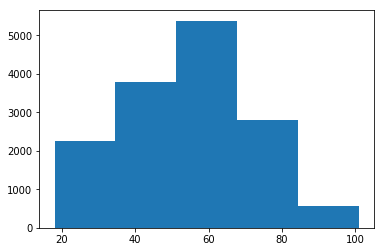

In [19]:
plt.hist(profile_df_copy['age'], bins=5); 

In [20]:
valid_income = profile_df_copy[profile_df_copy['income'].isna()==False]

(array([ 3438.,  4444.,  3780.,  2205.,   958.]),
 array([  30000.,   48000.,   66000.,   84000.,  102000.,  120000.]),
 <a list of 5 Patch objects>)

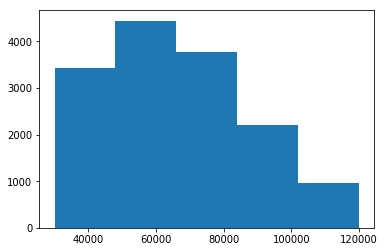

In [21]:
plt.hist(valid_income['income'], bins=5)

In [22]:
transcript_df.describe()

event,offer_completed,offer_received,offer_viewed
count,63288.000000,63288.000000,63288.00000
mean,0.530575,1.205236,0.91210
std,0.637582,0.453699,0.61458
min,0.000000,1.000000,0.00000
25%,0.000000,1.000000,1.00000
50%,0.000000,1.000000,1.00000
75%,1.000000,1.000000,1.00000
max,4.000000,5.000000,5.00000


### From the transaction descriptive statistics above, from the mean (offer completed = 0.53 and offer viewed = 0.91, about 39% difference), some of the customers that viewed the received offers were not able to complete the purchase whereas 67% of the offers received were not completed.

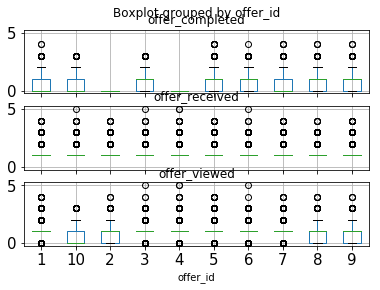

In [23]:
transcript_df_copy = transcript_df.copy()
offer_idx = list(set(transcript_df_copy.offer_id))
for i in range(len(offer_idx)):
    transcript_df_copy['offer_id'] = transcript_df_copy['offer_id'].apply(lambda x: '{}'.format(i+1) if x == offer_idx[i] else x)

boxplot = transcript_df_copy.boxplot(column=['offer_completed', 'offer_received', 'offer_viewed'], by='offer_id', layout=(3, 1), fontsize=15) 

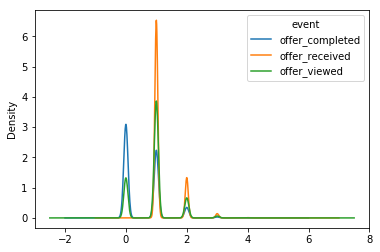

In [24]:
axes = transcript_df_copy.plot.kde()

#### From the above visual, although all the participants received the information to participate in the offers, only about to 38% of the population completed their offers.

### The merged data show the summary of the three datasets and also reveals the number of records available

In [25]:
merged_df.head(10)

,customer_id,offer_id,offer_successful,difficulty,duration,reward,email,mobile,social,web,...,offer_discount,offer_informational,age,became_member_on,gender,income,valid,gender_f,gender_m,gender_o
0,0009655768c64bdeb2e877511632db8f,9,0.0,10,7,2,1,1,0,1,...,1,0,33,1804,M,72000.0,1,0,1,0
1,0009655768c64bdeb2e877511632db8f,2,0.0,0,4,0,1,1,0,1,...,0,1,33,1804,M,72000.0,1,0,1,0
2,0009655768c64bdeb2e877511632db8f,4,0.0,0,3,0,1,1,1,0,...,0,1,33,1804,M,72000.0,1,0,1,0
3,0009655768c64bdeb2e877511632db8f,3,1.0,5,5,5,1,1,1,1,...,0,0,33,1804,M,72000.0,1,0,1,0
4,0009655768c64bdeb2e877511632db8f,6,1.0,10,10,2,1,1,1,1,...,1,0,33,1804,M,72000.0,1,0,1,0
5,00116118485d4dfda04fdbaba9a87b5c,3,0.0,5,5,5,1,1,1,1,...,0,0,118,1435,None,NaN,0,0,0,0
6,0011e0d4e6b944f998e987f904e8c1e5,10,1.0,20,10,5,1,0,0,1,...,1,0,40,1541,O,57000.0,1,0,0,1
7,0011e0d4e6b944f998e987f904e8c1e5,5,1.0,7,7,3,1,1,1,1,...,1,0,40,1541,O,57000.0,1,0,0,1
8,0011e0d4e6b944f998e987f904e8c1e5,2,0.0,0,4,0,1,1,0,1,...,0,1,40,1541,O,57000.0,1,0,0,1
9,0011e0d4e6b944f998e987f904e8c1e5,4,0.0,0,3,0,1,1,1,0,...,0,1,40,1541,O,57000.0,1,0,0,1


In [26]:
merged_df.describe()

,offer_successful,difficulty,duration,reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational,age,became_member_on,income,valid,gender_f,gender_m,gender_o
count,63288.000000,63288.000000,63288.000000,63288.000000,63288.0,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,55222.000000,63288.000000,63288.000000,63288.000000,63288.000000
mean,0.386487,7.711572,6.504819,4.206232,1.0,0.899286,0.599529,0.799425,0.400092,0.400013,0.199896,62.462110,1859.721053,65388.595125,0.872551,0.360384,0.500016,0.012151
std,0.486948,5.541480,2.203565,3.402914,0.0,0.300952,0.489998,0.400434,0.489921,0.489904,0.399925,26.729957,411.659882,21626.373809,0.333478,0.480116,0.500004,0.109560
min,0.000000,0.000000,3.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,1343.000000,30000.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,5.000000,2.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,45.000000,1551.000000,49000.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,10.000000,7.000000,5.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,58.000000,1701.000000,63000.000000,1.000000,0.000000,1.000000,0.000000
75%,1.000000,10.000000,7.000000,5.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,73.000000,2134.000000,80000.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,20.000000,10.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.000000,3166.000000,120000.000000,1.000000,1.000000,1.000000,1.000000


# Determine which demographic groups respond best to which offer type

In [27]:
merged_df[merged_df['offer_successful'] == 1].offer_id.value_counts()

6     4433
5     4313
3     3655
7     2843
1     2825
8     2504
9     2415
10    1472
Name: offer_id, dtype: int64

#### Provide descriptive statistics for all cases where customer's income was not reflected

In [28]:
merged_df[merged_df['income'].isnull()][['age', 'income']].describe()

,age,income
count,8066.0,0.0
mean,118.0,NaN
std,0.0,NaN
min,118.0,NaN
25%,118.0,NaN
50%,118.0,NaN
75%,118.0,NaN
max,118.0,NaN


#### Provide descriptive statistics for all cases where customers' income exist

In [29]:
merged_df[merged_df['income'].notnull()][['age', 'income']].describe()

,age,income
count,55222.000000,55222.000000
mean,54.349969,65388.595125
std,17.392733,21626.373809
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,63000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


#### Evaluate year membership record by year using the field became_member_on

In [ ]:
#start_year = merged_df['became_member_on'].apply(lambda x: x.year).value_counts()
#start_year

### Data Visualization (contd)

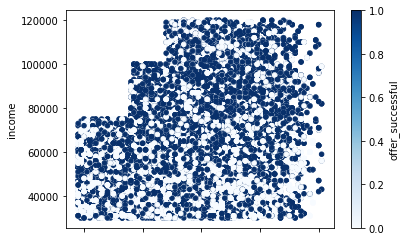

In [30]:
merged_df.plot.scatter(x='age', y='income', c='offer_successful', cmap='Blues')

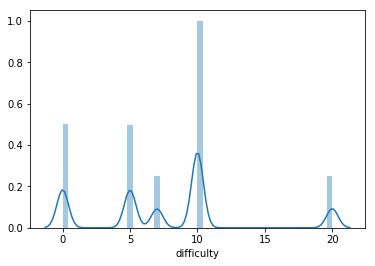

In [31]:
sns.distplot(merged_df['difficulty'].dropna())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
 <a list of 84 Text xticklabel objects>)

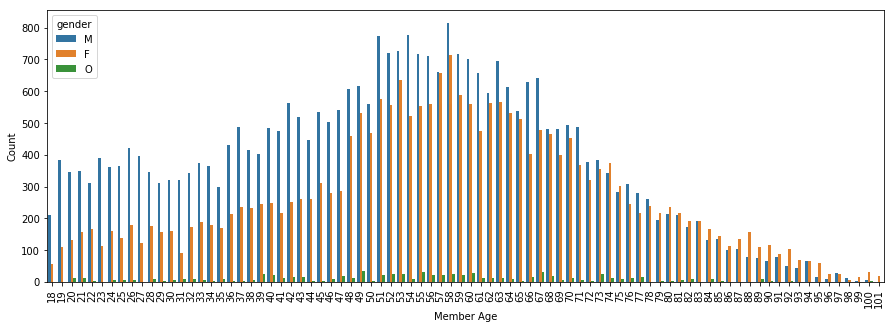

In [32]:
#get the summary of ages of the participants
age_df = merged_df.groupby(['gender', 'age']).size().sort_values(ascending=False) .reset_index(name='count') 
plt.figure(figsize=(15, 5))
sns.barplot(x='age', y='count', hue='gender', data=age_df)
plt.xlabel('Member Age')
plt.ylabel('Count')
plt.xticks(rotation=90)

### Plot distrribution of age by gender to see the response of each gender to offers accross ages

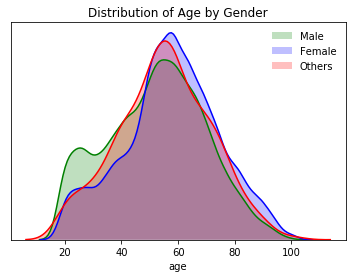

In [33]:
sns.distplot(merged_df[merged_df['gender']=='M']['age'],hist=False,color="g", kde_kws={"shade": True});
sns.distplot(merged_df[merged_df['gender']=='F']['age'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(merged_df[merged_df['gender']=='O']['age'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Distribution of Age by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female', 'Others'],frameon=False);

#### From the diagram above, maximum patronage occured at age between 40-70 accross all gender

#### Plot distrribution of income by gender to see the response of each gender to offers based on income

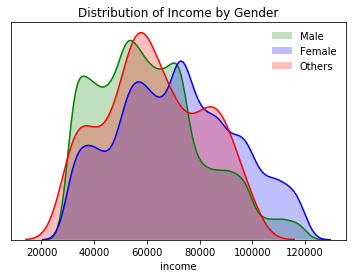

In [34]:
sns.distplot(merged_df[merged_df['gender']=='M']['income'],hist=False,color="g", kde_kws={"shade": True});
sns.distplot(merged_df[merged_df['gender']=='F']['income'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(merged_df[merged_df['gender']=='O']['income'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Distribution of Income by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female', 'Others'],frameon=False);

### Count of offers on Gender basis

Text(0,0.5,'Gender Count')

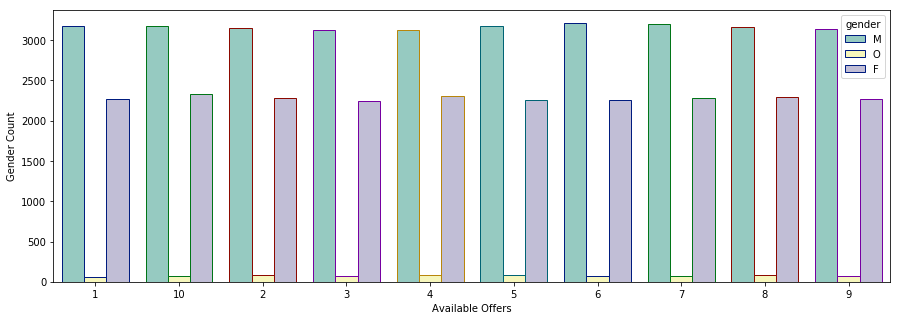

In [35]:
#gender_df = merged_df[merged_df['gender']=='M' or merged_df['gender']=='F']
plt.figure(figsize=(15, 5))
ax = sns.countplot(x="offer_id", hue="gender", data=merged_df, palette="Set3", edgecolor=sns.color_palette("dark", 12))
plt.xlabel('Available Offers')
plt.ylabel('Gender Count')

### Analysis of successful and unsuccessful offers based on status, income, duration, difficulty and reward

#### 1 Based on Status

Text(0.5,1,'Count of Offer Type')

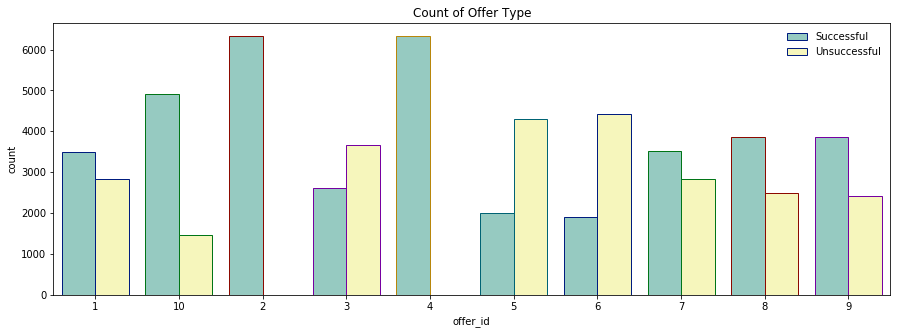

In [36]:
plt.figure(figsize=(15, 5))
sns.countplot(x='offer_id',hue='offer_successful',data=merged_df, palette="Set3", edgecolor=sns.color_palette("dark", 12));
plt.legend(['Successful', 'Unsuccessful'],frameon=False)
plt.title('Count of Offer Type')

#### 2. Based on Income

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


Text(0.5,1,'Distribution of Status of Offers by Income')

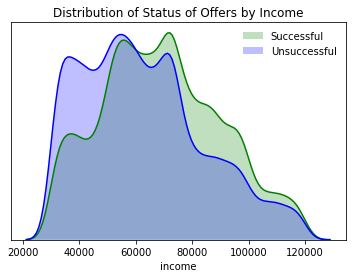

In [37]:
sns.distplot(merged_df[merged_df['offer_successful'] == 1]['income'],hist=False,color="g", kde_kws={"shade": True});
sns.distplot(merged_df[merged_df['offer_successful'] == 0]['income'],hist=False,color="b", kde_kws={"shade": True});
plt.legend(['Successful', 'Unsuccessful'],frameon=False)
plt.gca().get_yaxis().set_visible(False)
plt.title('Distribution of Status of Offers by Income')

#### 3. Based on Duration

Text(0.5,1,'Distribution of Status of Offers by Duration')

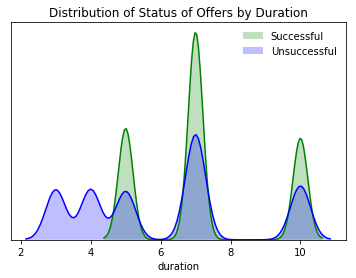

In [38]:
sns.distplot(merged_df[merged_df['offer_successful'] > 0]['duration'],hist=False,color="g", kde_kws={"shade": True});
sns.distplot(merged_df[merged_df['offer_successful']<= 0]['duration'],hist=False,color="b", kde_kws={"shade": True});
plt.legend(['Successful', 'Unsuccessful'],frameon=False)
plt.gca().get_yaxis().set_visible(False)
plt.title('Distribution of Status of Offers by Duration')

#### 4. Based on difficulty

Text(0.5,1,'Distribution of Status of Offers by difficulty')

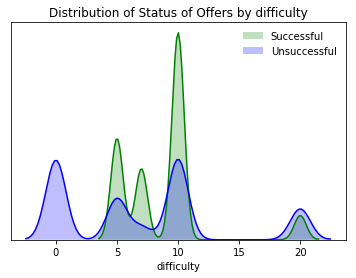

In [39]:
sns.distplot(merged_df[merged_df['offer_successful']> 0]['difficulty'],hist=False,color="g", kde_kws={"shade": True});
sns.distplot(merged_df[merged_df['offer_successful']<= 0]['difficulty'],hist=False,color="b", kde_kws={"shade": True});
plt.legend(['Successful', 'Unsuccessful'],frameon=False)
plt.gca().get_yaxis().set_visible(False)
plt.title('Distribution of Status of Offers by difficulty')

#### 5. Based on reward

Text(0.5,1,'Distribution of Status of Offers by reward')

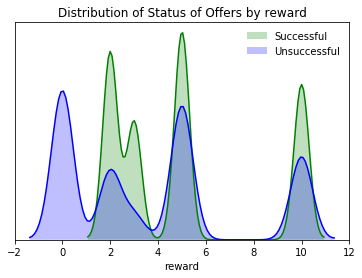

In [40]:
sns.distplot(merged_df[merged_df['offer_successful'] > 0]['reward'],hist=False,color="g", kde_kws={"shade": True});
sns.distplot(merged_df[merged_df['offer_successful'] <= 0]['reward'],hist=False,color="b", kde_kws={"shade": True});
plt.legend(['Successful', 'Unsuccessful'],frameon=False)
plt.gca().get_yaxis().set_visible(False)
plt.title('Distribution of Status of Offers by reward')

### Modeling

##### Let us explore the some modelling techniques to perform some exploratory analysis. Modeling techniques are used in data evaluation and analysis. We would reveal some important findings the best performing offers, etc using these modelling techniques.


In [41]:
merged_df.loc[merged_df['offer_successful'] == 1].head()

,customer_id,offer_id,offer_successful,difficulty,duration,reward,email,mobile,social,web,...,offer_discount,offer_informational,age,became_member_on,gender,income,valid,gender_f,gender_m,gender_o
3,0009655768c64bdeb2e877511632db8f,3,1.0,5,5,5,1,1,1,1,...,0,0,33,1804,M,72000.0,1,0,1,0
4,0009655768c64bdeb2e877511632db8f,6,1.0,10,10,2,1,1,1,1,...,1,0,33,1804,M,72000.0,1,0,1,0
6,0011e0d4e6b944f998e987f904e8c1e5,10,1.0,20,10,5,1,0,0,1,...,1,0,40,1541,O,57000.0,1,0,0,1
7,0011e0d4e6b944f998e987f904e8c1e5,5,1.0,7,7,3,1,1,1,1,...,1,0,40,1541,O,57000.0,1,0,0,1
10,0011e0d4e6b944f998e987f904e8c1e5,8,1.0,5,7,5,1,1,0,1,...,0,0,40,1541,O,57000.0,1,0,0,1


In [42]:
merged_df.drop(columns=['became_member_on', 'gender', 'valid', 'offer_successful']).iloc[:,1:].head()

,offer_id,difficulty,duration,reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational,age,income,gender_f,gender_m,gender_o
0,9,10,7,2,1,1,0,1,0,1,0,33,72000.0,0,1,0
1,2,0,4,0,1,1,0,1,0,0,1,33,72000.0,0,1,0
2,4,0,3,0,1,1,1,0,0,0,1,33,72000.0,0,1,0
3,3,5,5,5,1,1,1,1,1,0,0,33,72000.0,0,1,0
4,6,10,10,2,1,1,1,1,0,1,0,33,72000.0,0,1,0


In [43]:
merged_df.iloc[:,1].head()
merged_df.iloc[:,10:].head()

,offer_bogo,offer_discount,offer_informational,age,became_member_on,gender,income,valid,gender_f,gender_m,gender_o
0,0,1,0,33,1804,M,72000.0,1,0,1,0
1,0,0,1,33,1804,M,72000.0,1,0,1,0
2,0,0,1,33,1804,M,72000.0,1,0,1,0
3,1,0,0,33,1804,M,72000.0,1,0,1,0
4,0,1,0,33,1804,M,72000.0,1,0,1,0


In [44]:
merged_df.isnull().sum()

customer_id               0
offer_id                  0
offer_successful          0
difficulty                0
duration                  0
reward                    0
email                     0
mobile                    0
social                    0
web                       0
offer_bogo                0
offer_discount            0
offer_informational       0
age                       0
became_member_on          0
gender                 8066
income                 8066
valid                     0
gender_f                  0
gender_m                  0
gender_o                  0
dtype: int64

### Create a model function that would remove the gender field since dummy values had earlier been generated for the field, then fill missing values in the income field with the income mean value

In [45]:
def create_model_data(df):
    '''
    Description: Create a function that would return the  return X variables and the predictor Y
    Input 
        - merged_df
    output 
    - two dataframes X and Y
        X - return the collection of the merged data.
        Y - return the unique offer types.
    '''
    #drop categorical culumns from the experiment dataset
    my_model = df.copy()
    model_df = my_model.drop(columns=['gender', 'valid'])
    #We want to look at only successful offers
    model_df = model_df.loc[model_df['offer_successful'] == 1]
    #fill the missing values with mean of the field (data cleaning and workingwith missing values)
    model_df['income'] = model_df['income'].fillna(model_df['income'].mean())
    #gat all th rows from the 3rd colmun, focus on the quantitative data
    X = model_df.iloc[:,3:]
    
    #The the labels of all Offers
    Y= model_df.offer_id
    
    
    return X, Y

In [46]:
features, target_labels = create_model_data(merged_df)
features.shape, target_labels.shape

((24460, 16), (24460,))

In [47]:
target_labels.head()

3      3
4      6
6     10
7      5
10     8
Name: offer_id, dtype: object

In [48]:
features.head()

,difficulty,duration,reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational,age,became_member_on,income,gender_f,gender_m,gender_o
3,5,5,5,1,1,1,1,1,0,0,33,1804,72000.0,0,1,0
4,10,10,2,1,1,1,1,0,1,0,33,1804,72000.0,0,1,0
6,20,10,5,1,0,0,1,0,1,0,40,1541,57000.0,0,0,1
7,7,7,3,1,1,1,1,0,1,0,40,1541,57000.0,0,0,1
10,5,7,5,1,1,0,1,1,0,0,40,1541,57000.0,0,0,1


### 1. Using Random Forrest Classifier: 
#### In using this algorithm, it allows us to recommend the best offers for other customers using divide-and-conquer approach. It is a highly accurate and robust method because of the number of decision trees participating in the process . It does not suffer from the overfitting problem, takes the average of all the predictions, and cancels out the biases.

#### It works in four steps:
- Select random samples from a given dataset.
- Construct a decision tree for each sample and get a prediction result from each decision tree.
- Perform a vote for each predicted result.
- Select the prediction result with the most votes as the final prediction.


In [49]:
# Estimate the Scaling our inputs 
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(features)

In [50]:
#Use the experiment data to estimate the training and the test data sets
X_train, X_test, y_train, y_test = \
train_test_split(features,target_labels,test_size=.25,random_state=21)

X_train.shape, X_test.shape

((18345, 16), (6115, 16))

In [51]:
# Scaling our inputs 
min_max_scaler2 = preprocessing.MinMaxScaler()
X_train_fit = min_max_scaler2.fit_transform(X_train)
X_test_fit = min_max_scaler2.fit_transform(X_test)

In [52]:
#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_fit,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
#Predict possible Offers using the test dataset
y_pred=clf.predict(X_test_fit)

In [54]:
y_pred

array(['8', '5', '6', ..., '5', '5', '3'], dtype=object)

### Use Confusion Matrix to measure the accuracy of the prediction
* The Confuion Matrix allows us to visualize the performance of the classification machine learning models. With this visualization technique, we can get a better idea of how our machine learning model is performing
* We can look at a confusion matrix to see how much accurate classification and mis-classification there was. The diagonal indicates correct % of classification. Off diagonals indicate the % of times the model misclassified an offer.

In [55]:
#get the confusion matrix and the accuracy score
confusion = confusion_matrix(y_test,y_pred)
accuracy_score(y_test,y_pred)

1.0

In [56]:
confusion

array([[ 711,    0,    0,    0,    0,    0,    0,    0],
       [   0,  358,    0,    0,    0,    0,    0,    0],
       [   0,    0,  921,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1070,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1145,    0,    0,    0],
       [   0,    0,    0,    0,    0,  691,    0,    0],
       [   0,    0,    0,    0,    0,    0,  612,    0],
       [   0,    0,    0,    0,    0,    0,    0,  607]])

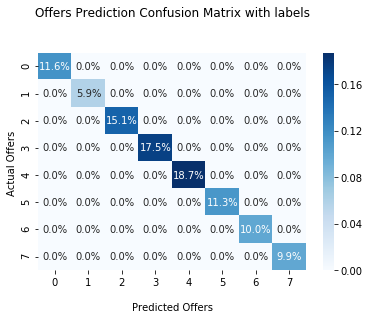

In [57]:
ax = sns.heatmap(confusion/np.sum(confusion), annot=True, fmt='.1%', cmap='Blues')
#ax = sns.heatmap(confusion,cmap='Blues')


ax.set_title('Offers Prediction Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Offers')
ax.set_ylabel('Actual Offers ');
plt.figure(figsize = (25,20))

## Display the visualization of the Confusion Matrix.
plt.show()

## Using Model to classify individual gata groups

### 1. To determine which demographic group that responded best to each offer
* Generate model data using the demographic collection

In [58]:
X,Y = create_model_data(merged_df)

#Only keep inforamtion in the X dataframe that refers to the user.
X = X.iloc[:, 10:]
X.head()

,age,became_member_on,income,gender_f,gender_m,gender_o
3,33,1804,72000.0,0,1,0
4,33,1804,72000.0,0,1,0
6,40,1541,57000.0,0,0,1
7,40,1541,57000.0,0,0,1
10,40,1541,57000.0,0,0,1


In [59]:
#Generate the train and test data for prediction
X_train, X_test, y_train, y_test = train_test_split(\
                        X,Y,test_size=.2,random_state=21)

#Normalize the data
sc = preprocessing .StandardScaler()
X_train=sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

#Instansiate Classifier
classifier = RandomForestClassifier(n_estimators=100)


#Train Classifier
classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
y_pred = classifier.predict(X_test)

print('Model accuracy: {0:0.2f}'.format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test,y_pred))

Model accuracy: 0.06
             precision    recall  f1-score   support

          1       0.04      0.04      0.04       571
         10       0.00      0.00      0.00       285
          3       0.06      0.06      0.06       737
          5       0.10      0.12      0.11       864
          6       0.12      0.12      0.12       909
          7       0.02      0.01      0.01       554
          8       0.03      0.03      0.03       485
          9       0.02      0.01      0.02       487

avg / total       0.06      0.06      0.06      4892



In [61]:
#Generate the confusion matrix
cf_matrix_std = confusion_matrix(y_test, y_pred)

In [62]:
cf_matrix_std

array([[ 22,  28,  94, 109, 111,  86,  60,  61],
       [ 35,   0,  45,  58,  36,  40,  42,  29],
       [ 88,  27,  41, 179, 168,  98,  64,  72],
       [106,  35, 150, 104, 206,  82, 101,  80],
       [ 95,  42, 155, 240, 110, 109,  84,  74],
       [ 88,  34, 100, 131, 104,   8,  46,  43],
       [ 59,  33,  67, 103, 108,  50,  15,  50],
       [ 67,  23,  68, 105, 113,  57,  47,   7]])

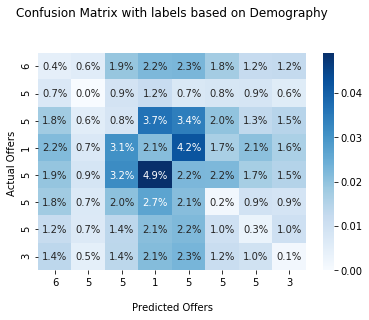

In [63]:
ax = sns.heatmap(cf_matrix_std/np.sum(cf_matrix_std), annot=True, fmt='.1%', cmap='Blues')
ax.set_title('Confusion Matrix with labels based on Demography\n\n');
ax.set_xlabel('\nPredicted Offers')
ax.set_ylabel('Actual Offers ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(y_pred)
ax.yaxis.set_ticklabels(y_pred)
## Display the visualization of the Confusion Matrix.
plt.show()

### To determine which Offer performed best among the offer types

In [64]:
X,Y = create_model_data(merged_df)

In [65]:
X = X.iloc[:, :10]
X.head()

,difficulty,duration,reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
3,5,5,5,1,1,1,1,1,0,0
4,10,10,2,1,1,1,1,0,1,0
6,20,10,5,1,0,0,1,0,1,0
7,7,7,3,1,1,1,1,0,1,0
10,5,7,5,1,1,0,1,1,0,0


In [66]:
#Generate the train and test data for prediction
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.2,random_state=21)

#Normalize the data
sc = preprocessing.StandardScaler()
X_train=sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

#Instansiate Classifier
classifier = RandomForestClassifier(n_estimators=20,criterion='entropy',random_state=42)


#Train Classifier
classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [67]:
y_pred = classifier.predict(X_test)

print('Model accuracy: {0:0.2f}'.format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test,y_pred))

Model accuracy: 1.00
             precision    recall  f1-score   support

          1       1.00      1.00      1.00       571
         10       1.00      1.00      1.00       285
          3       1.00      1.00      1.00       737
          5       1.00      1.00      1.00       864
          6       1.00      1.00      1.00       909
          7       1.00      1.00      1.00       554
          8       1.00      1.00      1.00       485
          9       1.00      1.00      1.00       487

avg / total       1.00      1.00      1.00      4892



In [68]:
#Generate the confusion matrix
cf_matrix_std_offers = confusion_matrix(y_test, y_pred)

In [69]:
cf_matrix_std_offers

array([[571,   0,   0,   0,   0,   0,   0,   0],
       [  0, 285,   0,   0,   0,   0,   0,   0],
       [  0,   0, 737,   0,   0,   0,   0,   0],
       [  0,   0,   0, 864,   0,   0,   0,   0],
       [  0,   0,   0,   0, 909,   0,   0,   0],
       [  0,   0,   0,   0,   0, 554,   0,   0],
       [  0,   0,   0,   0,   0,   0, 485,   0],
       [  0,   0,   0,   0,   0,   0,   0, 487]])

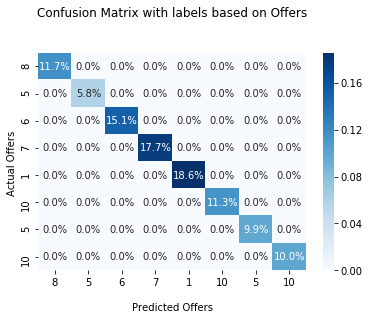

In [70]:
ax = sns.heatmap(cf_matrix_std_offers/np.sum(cf_matrix_std_offers), annot=True, fmt='.1%', cmap='Blues')
ax.set_title('Confusion Matrix with labels based on Offers\n\n');
ax.set_xlabel('\nPredicted Offers')
ax.set_ylabel('Actual Offers ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(y_pred)
ax.yaxis.set_ticklabels(y_pred)
## Display the visualization of the Confusion Matrix.
plt.show()

### Using Logistic Regression

- Gradient Boosting uses an ensemble of decision trees to predict a target label. However, unlike AdaBoost, the Gradient Boost trees have a depth larger than 1
- Calculate the average of the target label
- Calculate the residuals: For every sample, we calculate the residual with the proceeding formula. 
  * residual = actual value – predicted value
- Construct a decision tree
- Predict the target label using all of the trees within the ensemble
- Once trained, use all of the trees in the ensemble to make a final prediction as to the value of the target variable

### Use GridSearchCV to discover optimal parameters
https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [71]:
#create a model_pipeline
def model_pipeline(X_features, y_target):
    '''
    inputs:
    - X_features & y_target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_features,y_target, test_size=0.20, random_state=42)

    #fit and transform scaling on training data
    scaler= preprocessing.StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    
    return X_train,X_test,y_train, y_test

In [72]:
#define Grid Search function
def grid_search_random_forest(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    params={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [20,30,40,50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
    gs_cv = GridSearchCV(RandomForestClassifier(random_state=2), params)
    gs_cv.fit(X, y)
    gs_cv.best_params_
    
    return gs_cv.best_params_

In [73]:
# Split the dataset into training and test dataset
X,Y = create_model_data(merged_df)
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=1)

# Create a Logistic Regression Object, perform Logistic Regression
#using some information from 
#https://www.kaggle.com/code/enespolat/grid-search-with-logistic-regression/notebook
#https://www.datarmatics.com/data-science/how-to-perform-logistic-regression-in-pythonstep-by-step/

params = {
    'penalty': ['l1','l2'], 
    'C': [1,10,100,1000]
}

grid_cv = GridSearchCV(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                   penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                   verbose=3, warm_start=False), params, verbose=3, n_jobs=-1,cv=3)

In [74]:
grid_cv.fit(x_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=1, penalty=l1 .................................................
[LibLinear][CV] ....................... C=1, penalty=l1, score=1.0, total=   0.9s
[CV] C=1, penalty=l1 .................................................
[LibLinear]

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ....................... C=1, penalty=l1, score=1.0, total=   0.9s
[CV] C=1, penalty=l1 .................................................
[LibLinear]

[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] ....................... C=1, penalty=l1, score=1.0, total=   0.9s
[CV] C=1, penalty=l2 .................................................
[LibLinear][CV] ......... C=1, penalty=l2, score=0.955050670153645, total=   1.2s
[CV] C=1, penalty=l2 .................................................
[LibLinear][CV] ........ C=1, penalty=l2, score=0.8411841674844619, total=   1.2s
[CV] C=1, penalty=l2 .................................................
[LibLinear][CV] ........ C=1, penalty=l2, score=0.8835269098642238, total=   1.1s
[CV] C=10, penalty=l1 ................................................
[LibLinear][CV] ...................... C=10, penalty=l1, score=1.0, total=   0.7s
[CV] C=10, penalty=l1 ................................................
[LibLinear][CV] ...................... C=10, penalty=l1, score=1.0, total=   0.7s
[CV] C=10, penalty=l1 ................................................
[LibLinear][CV] ...................... C=10, penalty=l1, score=1.0, total=   0.6s
[CV] C=10, 

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   22.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=3, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [75]:
grid_cv.best_params_

{'C': 1, 'penalty': 'l1'}

In [76]:
logistic_y_pred = grid_cv.predict(x_test)
logistic_accuracy = accuracy_score(y_test,logistic_y_pred)
#logistic_f1 = f1_score(y_test,logistic_y_pred)

In [77]:
accuracy_score(y_test, logistic_y_pred)

1.0

In [78]:
#y_pred = log_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, logistic_y_pred)
print(classification_report(y_test, logistic_y_pred))
print(confusion_matrix(y_test, logistic_y_pred))
print(accuracy_score(y_test, logistic_y_pred))

print("tuned hpyerparameters :(best parameters) ", grid_cv.best_params_)
print("accuracy :",grid_cv.best_score_)

             precision    recall  f1-score   support

          1       1.00      1.00      1.00       748
         10       1.00      1.00      1.00       358
          3       1.00      1.00      1.00       919
          5       1.00      1.00      1.00      1066
          6       1.00      1.00      1.00      1098
          7       1.00      1.00      1.00       713
          8       1.00      1.00      1.00       610
          9       1.00      1.00      1.00       603

avg / total       1.00      1.00      1.00      6115

[[ 748    0    0    0    0    0    0    0]
 [   0  358    0    0    0    0    0    0]
 [   0    0  919    0    0    0    0    0]
 [   0    0    0 1066    0    0    0    0]
 [   0    0    0    0 1098    0    0    0]
 [   0    0    0    0    0  713    0    0]
 [   0    0    0    0    0    0  610    0]
 [   0    0    0    0    0    0    0  603]]
1.0
tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l1'}
accuracy : 1.0


### Convert categorical variable, offer ids designated as labels 1 - 10) into dummy/indicator variables. This would enable us understand how the offered performed across transactions and demography.

In [79]:
#Clean the income columns by filling Nan values with mean of the incomes
merged_df['income'] = merged_df['income'].fillna(merged_df['income'].mean())
X = merged_df.iloc[:,3:] #get all rows that represent quantitative data
y = merged_df.offer_successful #get all rows for offer_successful status

X = pd.concat([X, merged_df['offer_id']],axis=1)

In [80]:
dummies = pd.get_dummies(X['offer_id'])
adjusted = X.drop(['offer_id', 'gender', 'became_member_on'],axis=1)
merged_new = pd.concat([adjusted, dummies],axis=1)

In [81]:
merged_new.head()

,difficulty,duration,reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational,...,1,10,2,3,4,5,6,7,8,9
0,10,7,2,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,4,0,1,1,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,0,3,0,1,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,5,5,5,1,1,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,10,10,2,1,1,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


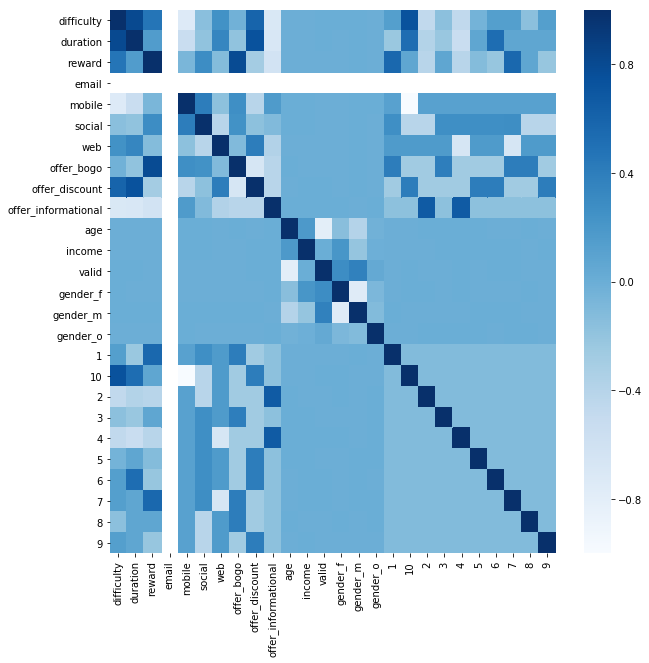

In [82]:
plt.figure(figsize=(10,10))
# calculate the correlation matrix
corr = merged_new.corr()

# plot the heatmap
#https://stackoverflow.com/questions/39409866/correlation-heatmap
sns.heatmap(corr, 
    xticklabels=merged_new.columns,
    yticklabels=merged_new.columns, 
    fmt='.1%', cmap='Blues')


In [83]:
#From the above diagram, there is a correlation on the email attribute. 
#This is because all customers that participated in the offers had their email addresses
#so let's drop the email field
X = merged_new.drop(['email'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state = 42)

scaler = preprocessing.MinMaxScaler()

In [84]:
X_train.head()

,difficulty,duration,reward,mobile,social,web,offer_bogo,offer_discount,offer_informational,age,...,1,10,2,3,4,5,6,7,8,9
15937,10,7,2,1,0,1,0,1,0,84,...,0,0,0,0,0,0,0,0,0,1
15639,10,7,10,1,1,0,1,0,0,118,...,0,0,0,0,0,0,0,1,0,0
25222,10,7,2,1,0,1,0,1,0,67,...,0,0,0,0,0,0,0,0,0,1
13047,10,7,2,1,0,1,0,1,0,56,...,0,0,0,0,0,0,0,0,0,1
2561,10,5,10,1,1,1,1,0,0,90,...,1,0,0,0,0,0,0,0,0,0


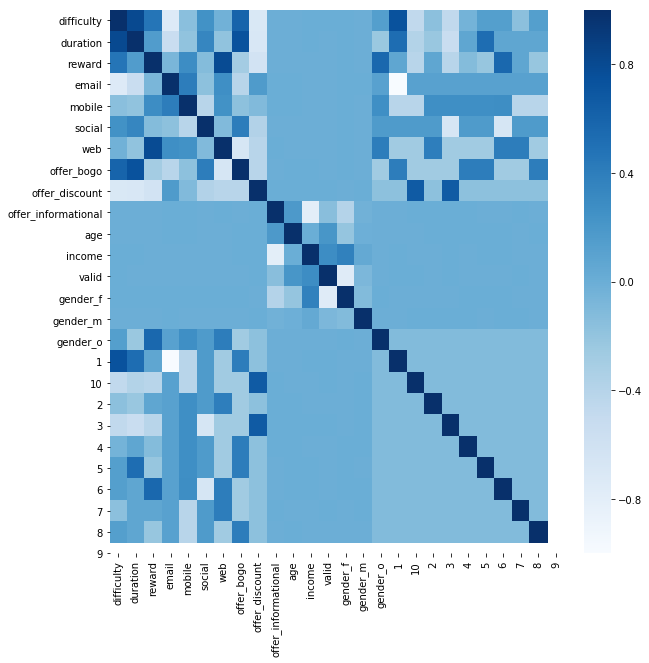

In [85]:
plt.figure(figsize=(10,10))
# calculate the correlation matrix
corr = X.corr()

# plot the heatmap
#https://stackoverflow.com/questions/39409866/correlation-heatmap
sns.heatmap(corr, 
    xticklabels=merged_new.columns,
    yticklabels=merged_new.columns, 
    fmt='.1%', cmap='Blues')

In [86]:
X_train = scaler.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)
logistic_model = LogisticRegression(solver='liblinear',random_state=42)

In [87]:
logistic_model.fit(X_train,y_train)
logistic_y_pred = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test,logistic_y_pred)

print("Logistic Regression Accuracy: %.2f" % accuracy_score(y_test, logistic_y_pred))

Logistic Regression Accuracy: 0.76


In [88]:
#Calculate the confusion matrix
confusion = confusion_matrix(y_test,logistic_y_pred)

In [89]:
print(confusion/np.sum(confusion))

[[ 0.49178385  0.12055617]
 [ 0.1224522   0.26520777]]


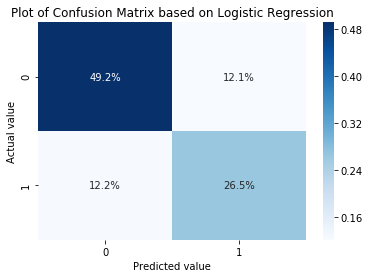

In [90]:
sns.heatmap(confusion/np.sum(confusion),annot=True, fmt='.1%', cmap='Blues')
plt.title('Plot of Confusion Matrix based on Logistic Regression')
plt.ylabel("Actual value")
plt.xlabel("Predicted value");

In [91]:
#calculate the F1 Score
logistic_f1 = f1_score(y_test,logistic_y_pred)
print("F1 Score for the Logistic Regression modle is: %.2f" % logistic_f1)

F1 Score for the Logistic Regression modle is: 0.69


#### Reapply the GridSearchCV Algorithm based on the Logistic Regression trained data

In [92]:
grid_cv2 = GridSearchCV(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                   penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                   verbose=3, warm_start=False), params, verbose=3, n_jobs=-1,cv=3)

In [93]:
grid_cv2.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=1, penalty=l1 .................................................
[LibLinear][CV] ........ C=1, penalty=l1, score=0.7561177934467026, total=  20.9s
[CV] C=1, penalty=l1 .................................................
[LibLinear]

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s


[CV] ........ C=1, penalty=l1, score=0.7514368667417195, total=  19.9s
[CV] C=1, penalty=l1 .................................................
[LibLinear]

[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   40.8s remaining:    0.0s


[CV] ........ C=1, penalty=l1, score=0.7454373074188196, total=  21.2s
[CV] C=1, penalty=l2 .................................................
[LibLinear][CV] ........ C=1, penalty=l2, score=0.7560585412099307, total=   0.3s
[CV] C=1, penalty=l2 .................................................
[LibLinear][CV] ........ C=1, penalty=l2, score=0.7513183622681756, total=   0.3s
[CV] C=1, penalty=l2 .................................................
[LibLinear][CV] ........ C=1, penalty=l2, score=0.7452002844275895, total=   0.3s
[CV] C=10, penalty=l1 ................................................
[LibLinear][CV] ....... C=10, penalty=l1, score=0.7565325591041062, total=   2.4s
[CV] C=10, penalty=l1 ................................................
[LibLinear][CV] ....... C=10, penalty=l1, score=0.7513776145049476, total=   4.2s
[CV] C=10, penalty=l1 ................................................
[LibLinear][CV] ....... C=10, penalty=l1, score=0.7450817729319744, total=   6.0s
[CV] C=10, 

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=3, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [94]:
grid_cv2.best_params_

{'C': 100, 'penalty': 'l2'}

In [95]:
logistic_y_pred2 = grid_cv2.predict(X_test)
logistic_accuracy2 = accuracy_score(y_test,logistic_y_pred2)
logistic_f12 = f1_score(y_test,logistic_y_pred2)

In [96]:
#Generate the Confusion matrix
conf_matrix2 = confusion_matrix(y_test, logistic_y_pred2)


print("See the classification report below:")
print(classification_report(y_test, logistic_y_pred2))
print("See the confusion matric below:")
print(conf_matrix2)
print("The accuracy from Logistic Regression using Grid Serch CV is: ", logistic_accuracy2)

print("Logistic Regression :(best parameters) ", grid_cv2.best_params_)
print("Logistic Regression accuracy :",grid_cv2.best_score_)

See the classification report below:
             precision    recall  f1-score   support

        0.0       0.80      0.80      0.80      7751
        1.0       0.69      0.68      0.69      4907

avg / total       0.76      0.76      0.76     12658

See the confusion matric below:
[[6220 1531]
 [1550 3357]]
The accuracy from Logistic Regression using Grid Serch CV is:  0.756596618739
Logistic Regression :(best parameters)  {'C': 100, 'penalty': 'l2'}
Logistic Regression accuracy : 0.751056685759


In [97]:
#Confusion Matrix expressed as a percentage
percent_conf = conf_matrix2/np.sum(conf_matrix2)

In [98]:
print("See the confusion matric below: (%)")
print(percent_conf)

See the confusion matric below: (%)
[[ 0.49138884  0.12095118]
 [ 0.1224522   0.26520777]]


In [99]:
print("Logistic Regression FI Score :",logistic_f12)

Logistic Regression FI Score : 0.685451761103


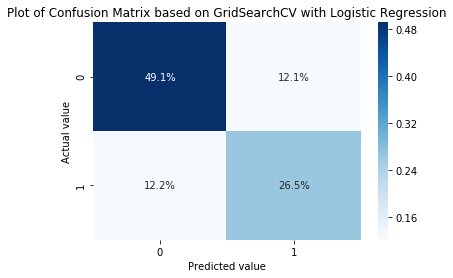

In [100]:
sns.heatmap(conf_matrix2/np.sum(conf_matrix2),annot=True, fmt='.1%', cmap='Blues')
plt.title('Plot of Confusion Matrix based on GridSearchCV with Logistic Regression')
plt.ylabel("Actual value")
plt.xlabel("Predicted value");